# Task 1

predictive_maintenance_dataset.csv is a file that contains parameters and settings: 
- operational_setting_1
- operational_setting_2
- sensor_measurement_1
- sensor_measurement_2
...            
for many wind turbines.        

There is a column called `unit_number` which specifies which turbine it is, and one called `status`, in which a value of 1 means the turbine broke down that day, and 0 means it didn't. 

Your task is to create a model that, when fed with operational settings and sensor measurements (unit_number and time_stamp will not be fed in), outputs 1 if the turbine will break down within the next 40 days, and 0 if not.

In [1]:
# Add the current path to the running path in order to import functions
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# basic libraries
import pickle
import numpy as np
import pandas as pd
import datetime as dt
from time import time
import missingno as msn

# preprocessing
from keras.utils.np_utils import to_categorical
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# model
from keras.models import Sequential
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_curve, accuracy_score, mean_squared_error

# for pipeline
from keras_model import keras_model
from reform_result import hard_label
from sklearn.pipeline import Pipeline
from create_labels import create_labels
from select_columns import select_columns
from sklearn.preprocessing import FunctionTransformer

# saving pipeline and model
from keras.models import load_model
from sklearn.externals import joblib

# viz
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

% matplotlib inline
rcParams['figure.figsize'] = 15, 6

Using TensorFlow backend.


In [3]:
# Load in data
df = pd.read_csv("../../data/predictive_maintenance_dataset.csv")

# Checking number of observation and features of the data
df.shape

(144203, 27)

In [4]:
# Glimpse at the data
df.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,540,2017-02-19 12:00:00,0,42.0007,0.8415,High,445.00,NaN,1362.47,1143.17,...,133.75,2388.50,8129.92,9.1182,NaN,332.0,2212.0,100.00,10.77,6.5717
1,396,2017-11-21 12:00:00,0,-0.0023,0.0004,High,518.67,642.33,1581.03,1400.06,...,522.19,2388.00,8135.70,8.3817,0.03,393.0,2388.0,100.00,39.07,23.3958
2,513,2017-02-12 12:00:00,0,NaN,0.6216,Low,462.54,536.71,1250.87,1037.52,...,163.11,2028.06,7867.90,10.8827,NaN,306.0,1915.0,84.93,14.33,8.6202
3,211,2014-06-05 12:00:00,0,42.0006,NaN,High,NaN,549.28,1349.42,1114.02,...,130.58,2387.71,8074.81,9.3776,0.02,NaN,2212.0,100.00,10.60,6.2614
4,460,2014-11-27 12:00:00,0,-0.0016,0.0004,High,518.67,643.84,1604.53,1431.41,...,519.44,2388.24,8135.95,8.5223,0.03,396.0,2388.0,100.00,38.39,23.0682


### Data type distribution

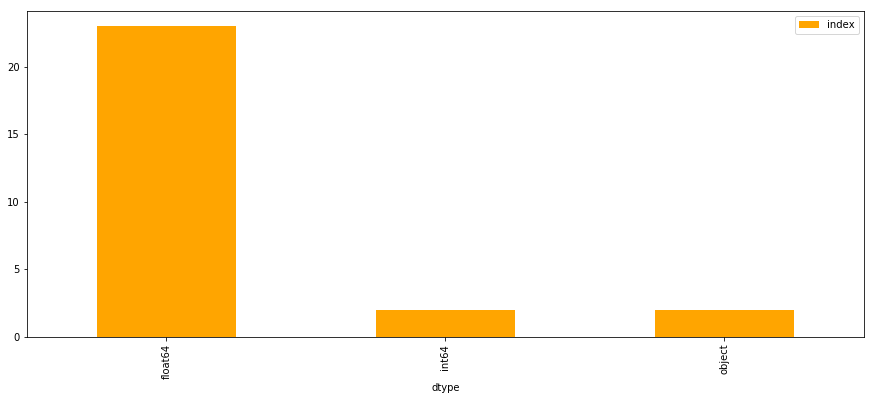

In [5]:
pd.DataFrame(df.dtypes.values, columns=['dtype']).reset_index().groupby('dtype').count()\
                                                .sort_values('index', ascending=False)\
                                                .plot(kind='bar', color="orange");

### Explore correlation

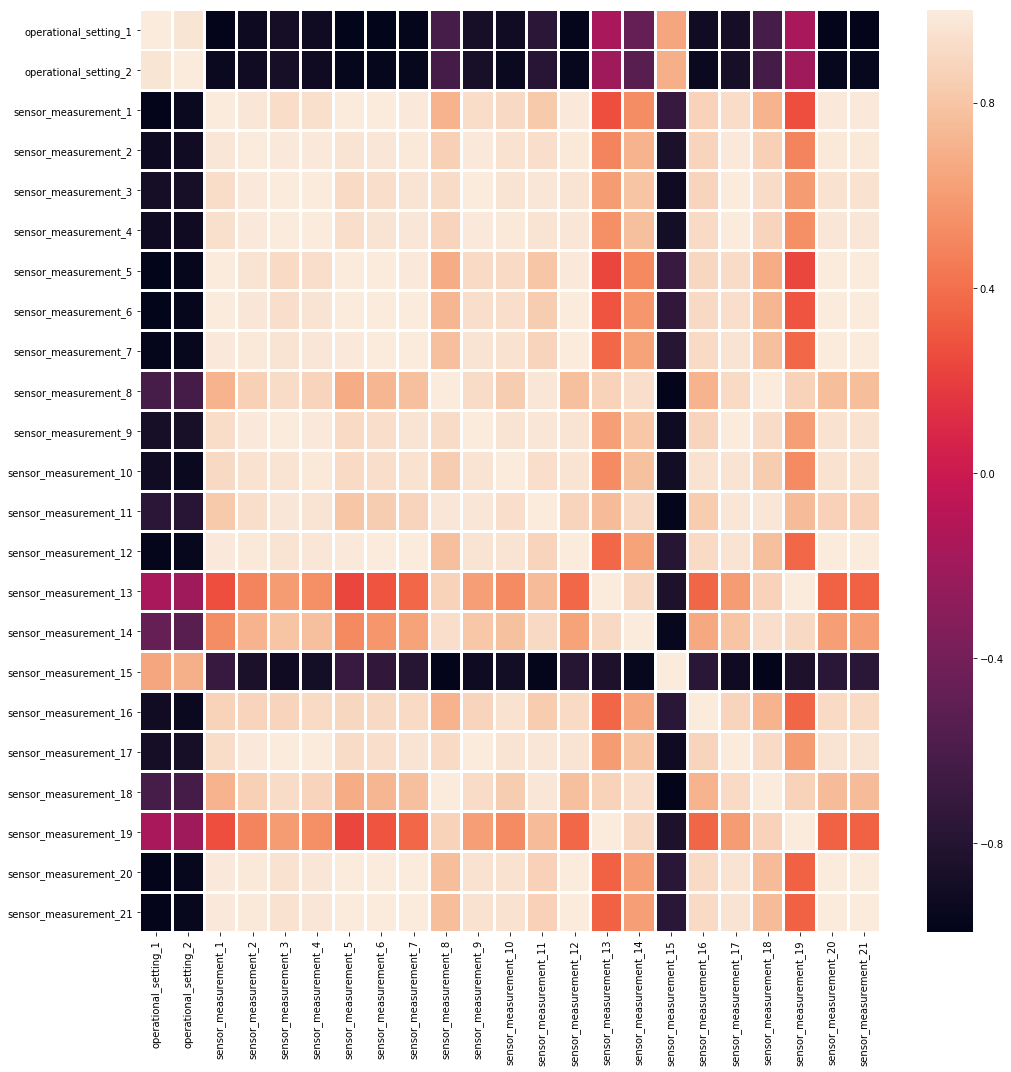

In [6]:
g = sns.FacetGrid(df.iloc[:,3:28], size=15)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(), linewidths=2));

It seems like there are many correlations, both positive and negative between features in the data. However, depend on the model using, I will need to perform feature selection.

### Checking missing value:
- Checking the missing pattern
- Checking the missing number

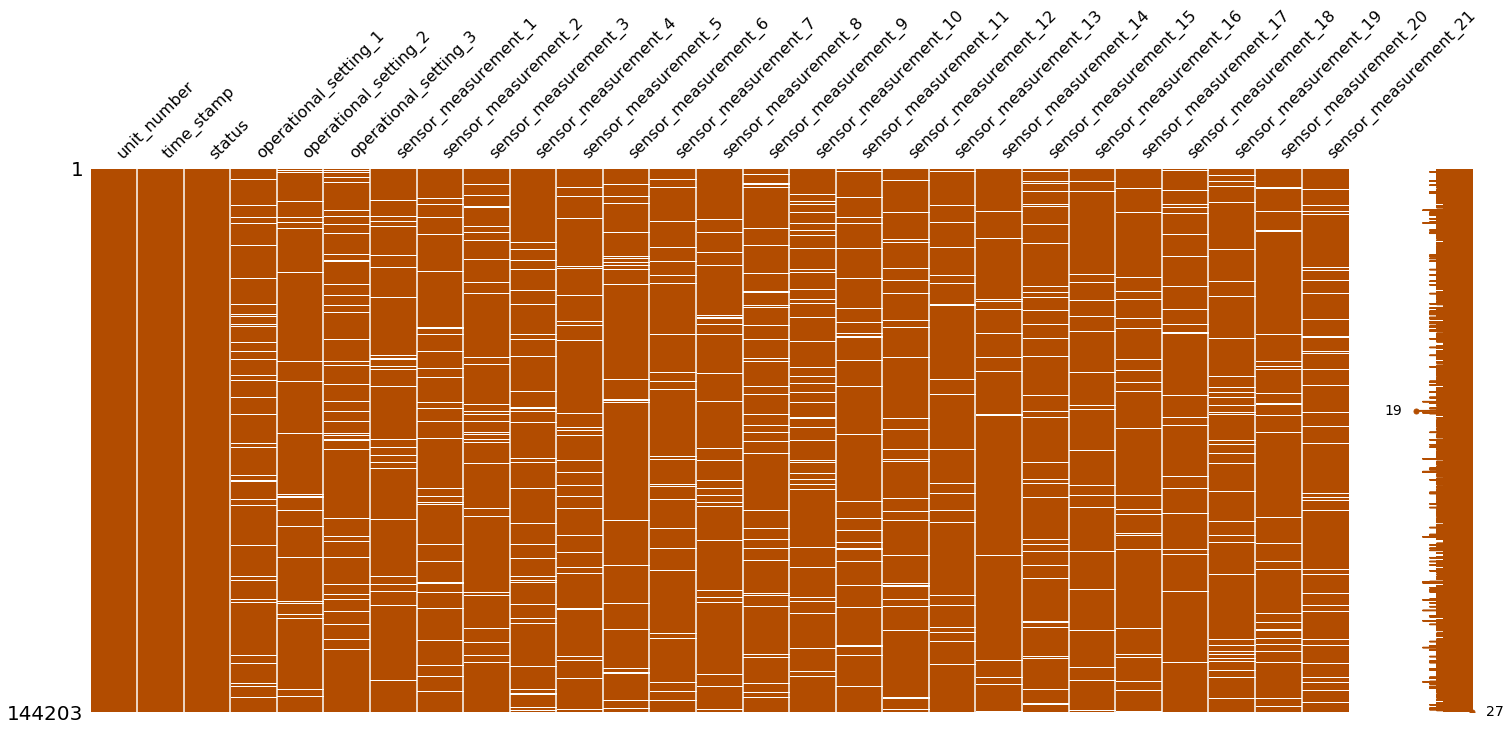

In [7]:
# white line is a missing value
msn.matrix(df, color=(0.7, 0.3, 0));

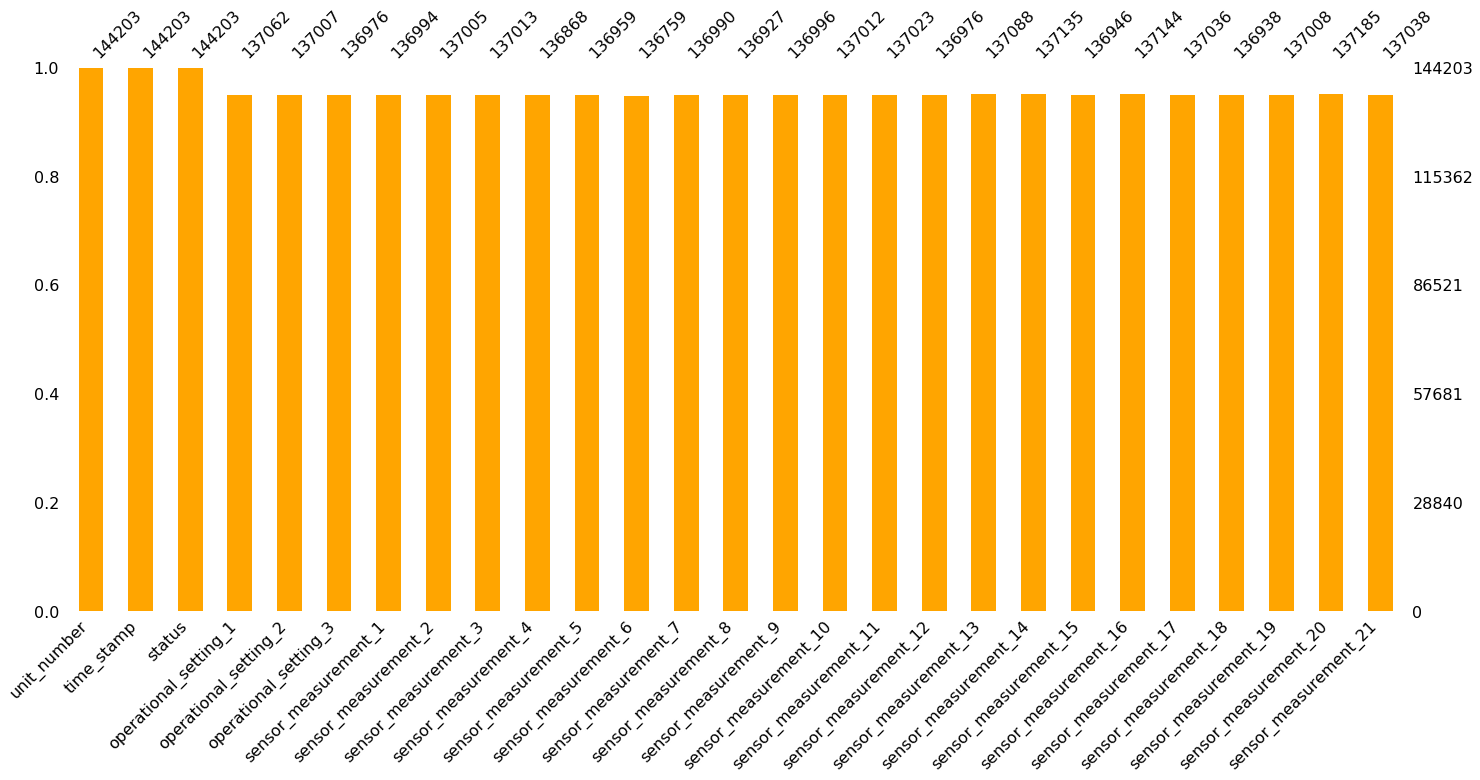

In [8]:
# Showing number of value for each column
msn.bar(df, color="orange");

In [9]:
# Take a look at each numerical feature statistically: 
df.iloc[:,3:28].describe()
# This could be good for imputing potentially

,operational_setting_1,operational_setting_2,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
count,137062.000000,137007.000000,136994.000000,137005.000000,137013.000000,136868.000000,136959.000000,136759.000000,136990.000000,136927.000000,...,136976.000000,137088.000000,137135.000000,136946.000000,137144.000000,137036.000000,136938.000000,137008.000000,137185.000000,137038.000000
mean,17.075966,0.406348,486.132686,597.771761,1468.144709,1262.295400,9.935961,14.487827,361.227447,2274.757600,...,340.434790,2349.903834,8089.449809,9.049490,0.025226,360.999569,2274.604843,98.402123,26.050472,15.631200
std,16.534306,0.368293,30.435453,42.514419,118.189101,136.348238,4.268740,6.447176,174.309332,142.335384,...,164.371761,110.837314,80.528884,0.751212,0.004995,31.017661,142.432048,4.639714,11.703273,7.022004
min,-0.008700,-0.000600,445.000000,535.480000,1242.980000,1023.770000,3.910000,5.670000,136.170000,1914.720000,...,128.450000,2027.570000,7848.360000,8.156300,0.020000,302.000000,1915.000000,84.930000,10.160000,6.091800
25%,0.001200,0.000200,449.440000,549.990000,1357.620000,1127.060000,5.480000,8.000000,175.730000,2212.130000,...,164.820000,2387.970000,8070.750000,8.437700,0.020000,332.000000,2212.000000,100.000000,14.340000,8.604525
50%,10.007800,0.251900,491.190000,606.520000,1493.670000,1293.970000,10.520000,15.460000,392.840000,2323.690000,...,370.220000,2388.070000,8119.710000,8.741350,0.030000,368.000000,2324.000000,100.000000,28.250000,16.944950
75%,35.001300,0.840000,518.670000,642.350000,1586.720000,1402.300000,14.620000,21.610000,553.320000,2388.050000,...,521.370000,2388.160000,8139.630000,9.343700,0.030000,392.000000,2388.000000,100.000000,38.830000,23.299000
max,42.008000,0.842000,518.670000,645.110000,1616.910000,1441.160000,14.620000,21.610000,570.810000,2388.640000,...,537.490000,2390.490000,8293.720000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.890000,23.950500


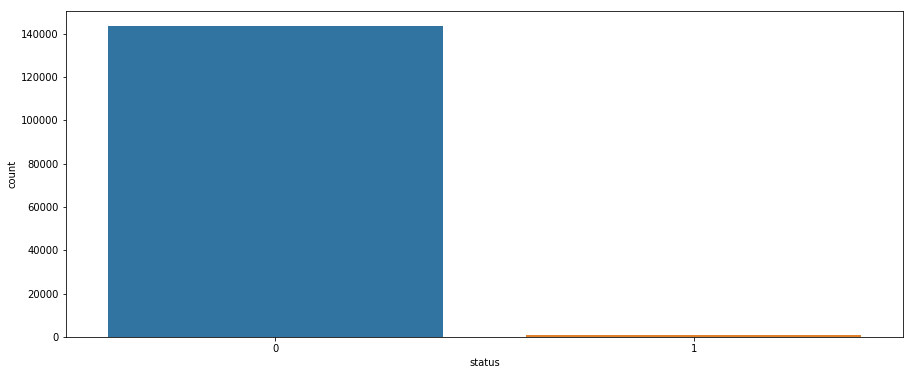

In [10]:
# Explore the status distribution
sns.countplot(x="status", data=df);

In [11]:
# Create label
new_df = create_labels(df)
new_df.head()

,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time,label
0,308,2014-01-01 12:00:00,0,41.9996,0.8400,High,445.00,548.98,1348.32,1115.01,...,8078.93,9.3585,0.02,330.0,2212.0,100.0,10.64,6.2918,2014-01-01,0
1,286,2014-01-01 12:00:00,0,20.0058,0.7008,NaN,491.19,606.98,1478.82,1246.69,...,8068.06,NaN,0.02,365.0,2324.0,100.0,24.58,14.7213,2014-01-01,0
2,22,2014-01-01 12:00:00,0,NaN,-0.0003,High,518.67,642.68,1595.65,1408.51,...,8127.45,8.4425,0.03,393.0,2388.0,100.0,38.96,23.3081,2014-01-01,0
3,122,2014-01-01 12:00:00,0,0.0002,0.0000,High,518.67,642.35,NaN,1396.41,...,8136.80,8.3946,0.03,394.0,2388.0,NaN,39.04,NaN,2014-01-01,0
4,360,2014-01-01 12:00:00,0,34.9989,NaN,High,449.44,NaN,1371.34,1121.46,...,8064.58,9.2879,0.02,334.0,2223.0,100.0,14.88,8.9362,2014-01-01,0


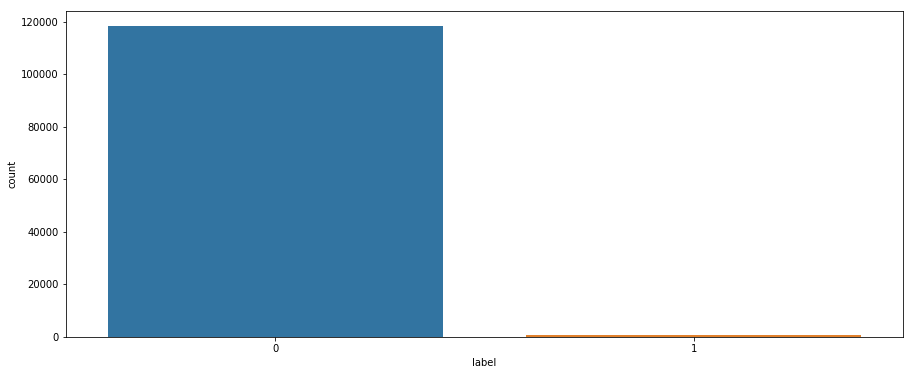

In [12]:
# Explore the label distribution of new label
sns.countplot(x="label", data=new_df);
# still very imbalanced

In [13]:
# Create new column of total date of each wind turbine (for exploration purpose)
new_df["total_date"] = new_df.groupby("unit_number")['time_stamp'].transform(lambda g: g.iloc[-1] - g.iloc[0])
new_df[["time_stamp","unit_number","total_date"]].head()

,time_stamp,unit_number,total_date
0,2014-01-01 12:00:00,308,109 days
1,2014-01-01 12:00:00,286,153 days
2,2014-01-01 12:00:00,22,161 days
3,2014-01-01 12:00:00,122,151 days
4,2014-01-01 12:00:00,360,275 days


Looking at the number of total date for all wind turbine. An average number is around 200 - 250 days for each wind turbine. The plot below demonstrates it:

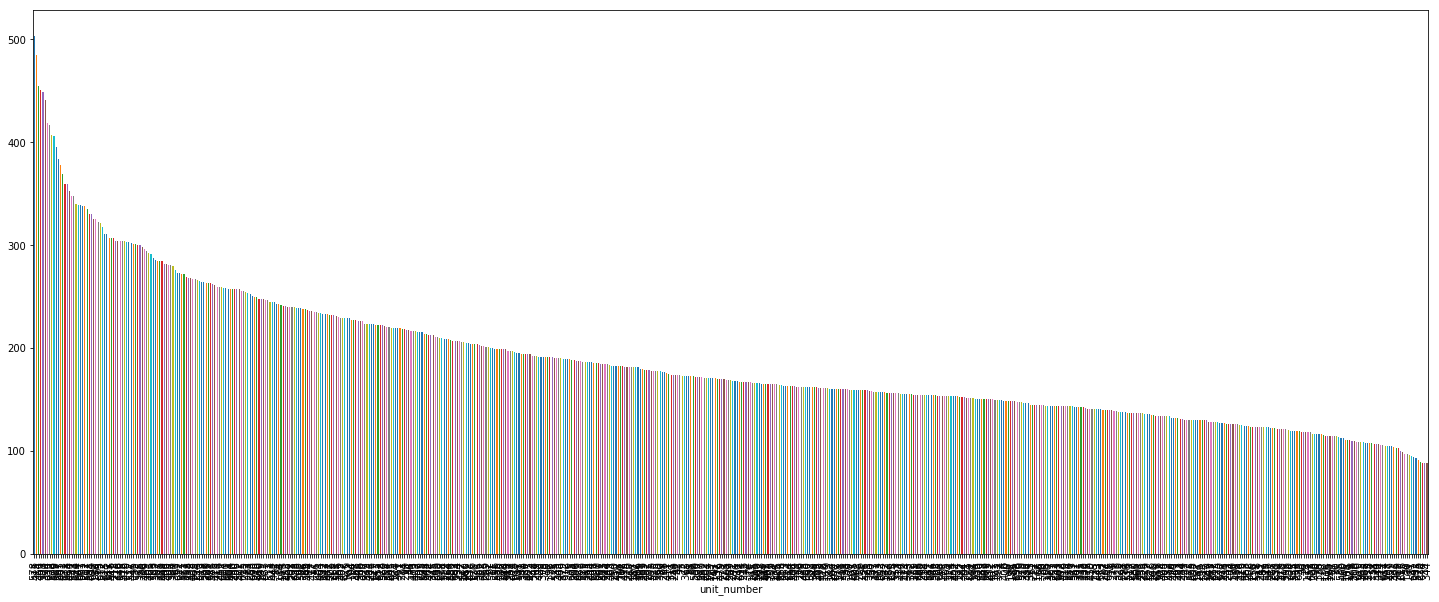

In [14]:
new_df[["time_stamp","unit_number","total_date"]].groupby("unit_number").size()\
                                                .sort_values(ascending=False).plot.bar(figsize=(25, 10));

### Preliminary cleaning and wrangling the data

- To use with some basic models
- Use original data with pipeline later

In [15]:
# Drop all row that has missing value:
wind_turbine = new_df.dropna()
wind_turbine.shape

(34678, 30)

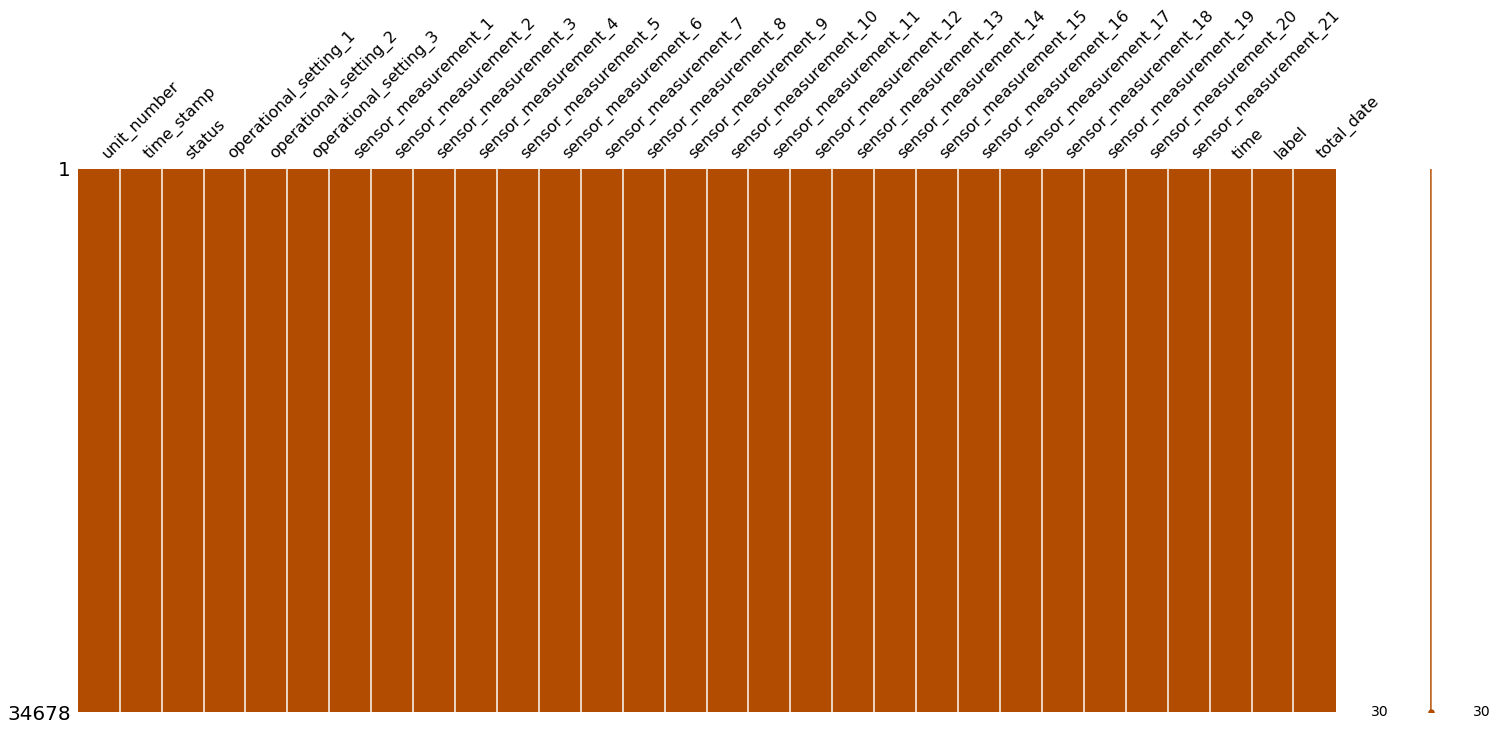

In [16]:
# Check if all NA has been removed:
msn.matrix(wind_turbine, color=(0.7, 0.3, 0));

In [17]:
wind_turbine.groupby("unit_number").count().head()

,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time,label,total_date
unit_number,,,,,,,,,,,,,,,,,,,,,
2,81,81,81,81,81,81,81,81,81,81,...,81,81,81,81,81,81,81,81,81,81
3,41,41,41,41,41,41,41,41,41,41,...,41,41,41,41,41,41,41,41,41,41
4,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
5,64,64,64,64,64,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64
6,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42


### Modelling

For this time series problem, I will split by time. As previouslly explore, I have the data from 2014 to 2018. So my splitting will be like below:
- Validation set: 2018
- Test set : 2017
- Train set:  2014, 2015, 2016

In [18]:
# Create a list of features needed
X_col = [ i for i in wind_turbine.columns if i not in ['unit_number', 'time', 'total_date', 'status', 'label']]

In [19]:
# Create X, y
X = wind_turbine[X_col]
y = wind_turbine[["label","time_stamp"]] # keeping time_stamp to split train test validation

In [20]:
# Split Train, Test, Validation set

# For X
Xval = X[X['time_stamp'].dt.year==2018].loc[:, X.columns != "time_stamp"]
Xtest = X[X['time_stamp'].dt.year == 2017].loc[:,X.columns != "time_stamp"]
Xtrain = X[X['time_stamp'].dt.year<2017].loc[:,X.columns != "time_stamp"]

# For y:
yval = y[y['time_stamp'].dt.year==2018]['label']
ytest = y[y['time_stamp'].dt.year == 2017]['label']
ytrain = y[y['time_stamp'].dt.year<2017]['label']

In [21]:
Xtrain.columns == Xtest.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [22]:
Xtrain.columns == Xval.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [23]:
# Transform categorical for upsizing train data
Xtrain = pd.get_dummies(Xtrain)
Xtrain.head()

,operational_setting_1,operational_setting_2,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,operational_setting_3_High,operational_setting_3_Low
6,10.0029,0.2511,489.05,604.73,1496.59,1305.02,10.52,15.49,395.29,2318.82,...,8135.48,8.6057,0.03,366.0,2319.0,100.00,28.74,17.1307,1,0
8,25.0071,0.6200,462.54,537.00,1257.79,1046.50,7.05,9.03,175.33,1915.46,...,7880.20,10.8643,0.02,305.0,1915.0,84.93,14.25,8.6234,0,1
13,41.9991,0.8416,445.00,548.88,1351.14,1123.82,3.91,5.71,138.92,2211.82,...,8081.67,9.3457,0.02,329.0,2212.0,100.00,10.67,6.3425,1,0
15,24.9981,0.6216,462.54,536.88,1264.02,1054.22,7.05,9.03,176.15,1915.22,...,7870.69,10.9144,0.02,308.0,1915.0,84.93,14.31,8.5945,0,1
17,19.9987,0.7012,491.19,607.08,1481.04,1243.92,9.35,13.65,334.84,2323.92,...,8066.41,9.1915,0.02,364.0,2324.0,100.00,24.49,14.7063,1,0


In [24]:
# Upsizing the data:
sm = SMOTE(random_state=39)
Xtrain_res, ytrain_res = sm.fit_sample(Xtrain, ytrain)

In [25]:
print("There are {} observation before the Upsampling, and {} obs after".format(Xtrain.shape[0], Xtrain_res.shape[0]))

There are 24489 observation before the Upsampling, and 48738 obs after


In [26]:
Xtrain_res = pd.DataFrame(Xtrain_res, columns=list(Xtrain.columns.values))
Xtrain_res.head()

,operational_setting_1,operational_setting_2,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,operational_setting_3_High,operational_setting_3_Low
0,10.0029,0.2511,489.05,604.73,1496.59,1305.02,10.52,15.49,395.29,2318.82,...,8135.48,8.6057,0.03,366.0,2319.0,100.00,28.74,17.1307,1.0,0.0
1,25.0071,0.6200,462.54,537.00,1257.79,1046.50,7.05,9.03,175.33,1915.46,...,7880.20,10.8643,0.02,305.0,1915.0,84.93,14.25,8.6234,0.0,1.0
2,41.9991,0.8416,445.00,548.88,1351.14,1123.82,3.91,5.71,138.92,2211.82,...,8081.67,9.3457,0.02,329.0,2212.0,100.00,10.67,6.3425,1.0,0.0
3,24.9981,0.6216,462.54,536.88,1264.02,1054.22,7.05,9.03,176.15,1915.22,...,7870.69,10.9144,0.02,308.0,1915.0,84.93,14.31,8.5945,0.0,1.0
4,19.9987,0.7012,491.19,607.08,1481.04,1243.92,9.35,13.65,334.84,2323.92,...,8066.41,9.1915,0.02,364.0,2324.0,100.00,24.49,14.7063,1.0,0.0


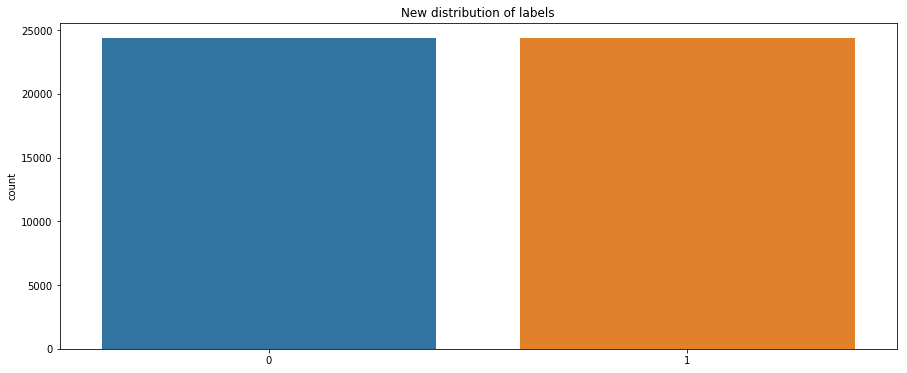

In [27]:
# new distribution of labels:
sns.countplot(x=ytrain_res).set_title('New distribution of labels');

In [28]:
# Create list of all freatures needed for the pipeline
X_col = Xtrain_res.columns.values
X_col

array(['operational_setting_1', 'operational_setting_2',
       'sensor_measurement_1', 'sensor_measurement_2',
       'sensor_measurement_3', 'sensor_measurement_4',
       'sensor_measurement_5', 'sensor_measurement_6',
       'sensor_measurement_7', 'sensor_measurement_8',
       'sensor_measurement_9', 'sensor_measurement_10',
       'sensor_measurement_11', 'sensor_measurement_12',
       'sensor_measurement_13', 'sensor_measurement_14',
       'sensor_measurement_15', 'sensor_measurement_16',
       'sensor_measurement_17', 'sensor_measurement_18',
       'sensor_measurement_19', 'sensor_measurement_20',
       'sensor_measurement_21', 'operational_setting_3_High',
       'operational_setting_3_Low'], dtype=object)

### Fitting general models

Fitting Logistic Regression model...
Train accuracy is: 0.892
Test accuracy is: 0.851
Confusion Maxtric for Logistic Regression model


c:\intelpython3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


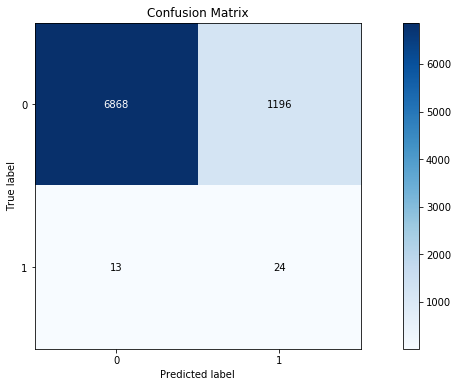

ROC curve for Logistic Regression model with test data


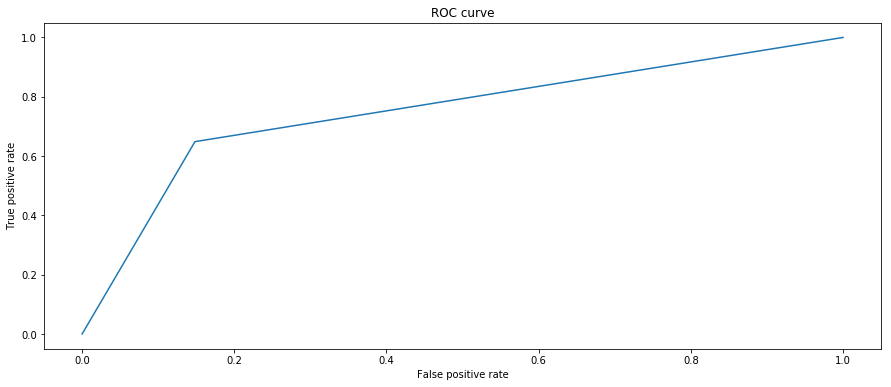

Fitting Random Forest Classifier model...
Train accuracy is: 1.0
Test accuracy is: 0.993
Confusion Maxtric for Random Forest Classifier model


c:\intelpython3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


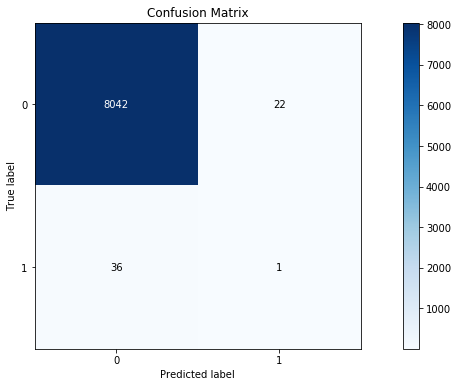

ROC curve for Random Forest Classifier model with test data


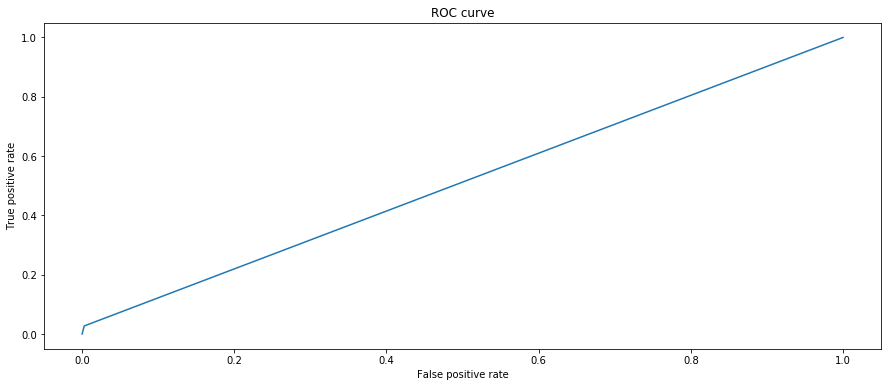

Fitting K Nearest Neighbor model...
Train accuracy is: 0.975
Test accuracy is: 0.929
Confusion Maxtric for K Nearest Neighbor model


c:\intelpython3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


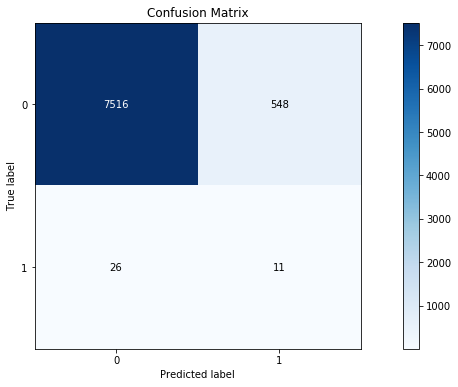

ROC curve for K Nearest Neighbor model with test data


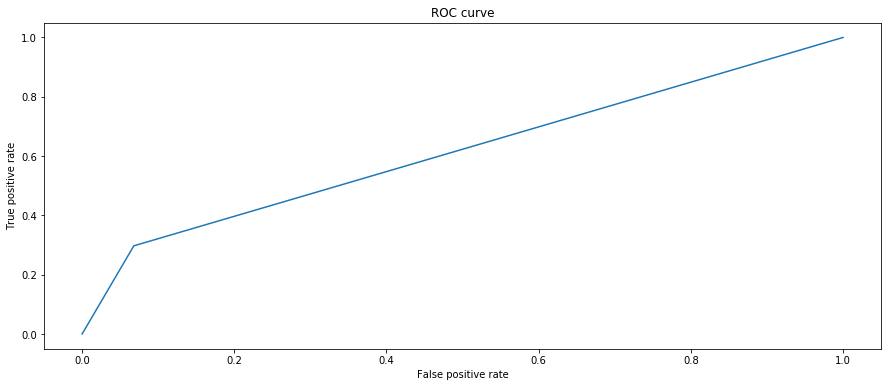

In [29]:
# Fitting general models:
model_list = {"Logistic Regression": LR(),
              "Random Forest Classifier": RFC(),
              "K Nearest Neighbor": KNN()
             }

for k, v in model_list.items():
    pl = Pipeline([
        ('get_dummies', FunctionTransformer(pd.get_dummies, validate=False)),
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0)),
        ('model', v)
    ])
    
    print("Fitting {} model...".format(k))
    pl.fit(Xtrain_res, ytrain_res)
    print("Train accuracy is:", accuracy_score(ytrain_res, pl.predict(Xtrain_res)).round(3))
    ypred = pl.predict(Xtest)
    print("Test accuracy is:", accuracy_score(ytest, ypred).round(3))
    print("Confusion Maxtric for {} model".format(k))
    skplt.metrics.plot_confusion_matrix(ytest, ypred)
    plt.show()
    
    print("ROC curve for {} model with test data".format(k))
    rocx, rocy, _ = roc_curve(ytest, ypred)
    
    plt.plot(rocx, rocy)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()

The ROC curves shows that even the accuracy is good and confusion matrix seems fine, the generalization ability of these model are not useful. Moving to use Neural Network.

### Creating Pipeline 
- Setting up pipeline
- Fitting to the clean, balanced training dataset
- Testing with the imbalanced, messy test set
- Assess MSE 

In [30]:
# Using TensorBoard to track on accuracy/ loss and each steps inside Keras model.
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [31]:
# Setting up the Keras model:
estimator = KerasClassifier(build_fn=keras_model, epochs=10, batch_size=5, verbose=1, callbacks=[tensorboard])

# Build pipeline
pl = Pipeline([
        ('get_dummies', FunctionTransformer(pd.get_dummies, validate=False)),
        ('subset', FunctionTransformer(select_columns, kw_args={'col_names':X_col}, validate=False)),
        ('impute', Imputer(missing_values='NaN',
                            strategy="mean",
                            axis=0)),
        ('model', estimator)
    ])

In [32]:
# Fit to the balanced training data
pl.fit(Xtrain_res, ytrain_res)

Epoch 1/10
48738/48738 [==============================] - 34s 688us/step - loss: 0.2130 - acc: 0.6563
Epoch 2/10
48738/48738 [==============================] - 34s 701us/step - loss: 0.1944 - acc: 0.7016
Epoch 3/10
48738/48738 [==============================] - 33s 679us/step - loss: 0.1882 - acc: 0.7096
Epoch 4/10
48738/48738 [==============================] - 33s 668us/step - loss: 0.1857 - acc: 0.7175
Epoch 5/10
48738/48738 [==============================] - 35s 728us/step - loss: 0.1842 - acc: 0.7187
Epoch 6/10
48738/48738 [==============================] - 33s 683us/step - loss: 0.1829 - acc: 0.7238
Epoch 7/10
48738/48738 [==============================] - 35s 724us/step - loss: 0.1825 - acc: 0.7234
Epoch 8/10
48738/48738 [==============================] - 35s 728us/step - loss: 0.1821 - acc: 0.7236
Epoch 9/10
48738/48738 [==============================] - 36s 749us/step - loss: 0.1804 - acc: 0.7285
Epoch 10/10
48738/48738 [==============================] - 33s 684us/step - loss: 

Pipeline(memory=None,
     steps=[('get_dummies', FunctionTransformer(accept_sparse=False,
          func=<function get_dummies at 0x0000021BD9951E18>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('subset', FunctionTransformer(accept_sparse=False,
          fun... verbose=0)), ('model', <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000021B81206438>)])

In [33]:
# Compute and print MSE from imbalanced, messy test data:
ypred = pl.predict(Xtest)
mse = mean_squared_error(ytest, ypred)
print("Mean squared error: %f" % (mse))

8101/8101 [==============================] - 1s 172us/step
Mean squared error: 0.222689


ROC curve for Feed Forward neural network model with test data


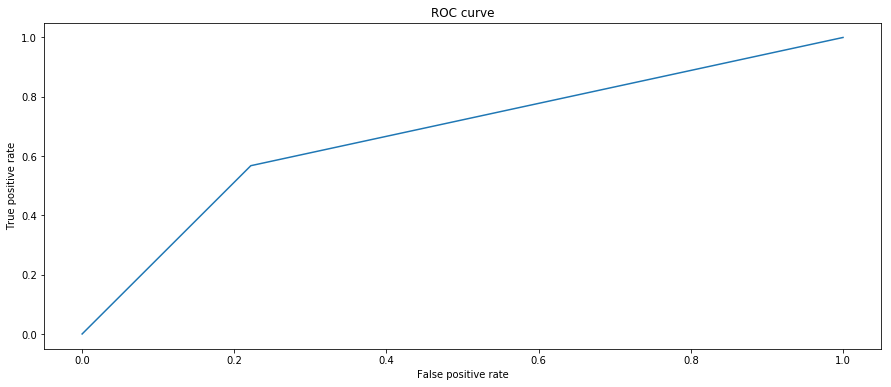

In [36]:
print("ROC curve for Feed Forward neural network model with test data")
rocx, rocy, _ = roc_curve(ytest, ypred)

plt.plot(rocx, rocy)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

This shows that it is a little better than the Logistic Regression above, but not ideally.

In [37]:
# Compute the test accuracy:

# reset index for comparison
ytest2 = ytest.reset_index(drop=True)

# Hard label the prediction
new_ypred=pd.DataFrame(ypred)[0].apply(hard_label)

accuracy = float(np.sum(new_ypred==ytest2))/ytest2.shape[0]
print("accuracy: {}%".format(round(accuracy*100, 3)))

accuracy: 77.731%


In [38]:
# Compute and print MSE for validation
ypred = pl.predict(Xval)
mse = mean_squared_error(yval, ypred)
print("Mean squared error: %f" % (mse))

# reset index for comparison
yval2 = yval.reset_index(drop=True)

# assign hard label
new_ypred=pd.DataFrame(ypred)[0].apply(hard_label)

# Compute the accuracy: accuracy for validation
accuracy = float(np.sum(new_ypred==yval2))/yval2.shape[0]
print("accuracy: {}%".format(round(accuracy*100, 3)))

2088/2088 [==============================] - 0s 208us/step
Mean squared error: 0.340996
accuracy: 65.9%


## Conclusion
This seems okay. I will now save the model.
I may try train the model with the whole dataset that I have to get the most information from it. (will need to balance the whole dataset).

In [50]:
# Save the Keras model first:
pl.named_steps['model'].model.save('../../results/task1_keras_model.h5')

# Skip the model from pipeline:
pl.named_steps['model'].model = None

# Save the pipeline:
joblib.dump(pl, '../../results/task1_pipeline.pkl')

['../../results/task1_pipeline.pkl']

### Downgrade Keras 2.0 --> 1.2 to check load in model and make prediction:

In [42]:
# Load the pipeline first:
pl_load_in = joblib.load('../../results/task1_pipeline.pkl')

# Then, load the Keras model:
pl_load_in.named_steps['model'].model = load_model('../../results/task1_keras_model.h5')

In [43]:
# Compute and print MSE for validation
ypred = pl_load_in.predict(Xval)
mse = mean_squared_error(yval, ypred)
print("Mean squared error: %f" % (mse))

# reset index for comparison
yval2 = yval.reset_index(drop=True)

# assign hard label
new_ypred=pd.DataFrame(ypred)[0].apply(hard_label)

# Compute the accuracy: accuracy for validation
accuracy = float(np.sum(new_ypred==yval2))/yval2.shape[0]
print("accuracy: {}%".format(round(accuracy*100, 3)))

2088/2088 [==============================] - 0s     
Mean squared error: 0.264847
accuracy: 73.515%
